### Libs

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import 

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

/home/diogo/Documents/projetos-teste/time_series_studies/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### Importing the data

In [2]:
df = pd.read_csv('solar-cargas-dia-fortal.csv', 
                index_col=[0],
                parse_dates=[0])
df.head()

,total_loads
start_of_operation,
2023-01-02,95
2023-01-03,92
2023-01-04,92
2023-01-05,100
2023-01-06,92


### Gereral data - Vizualization

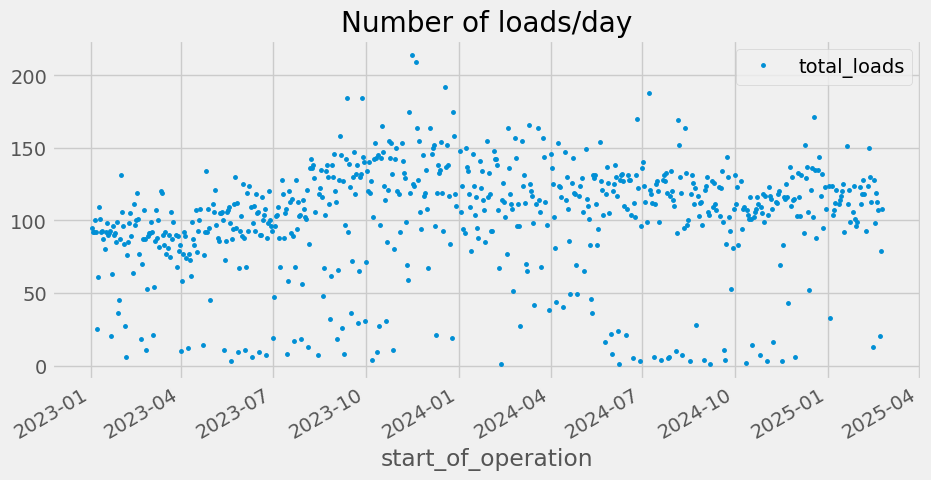

In [3]:
palette_color = sns.color_palette()
df.plot(style='.',
       figsize=(10,5),
       ms=5,
       color=palette_color[0],
       title='Number of loads/day')
plt.show()

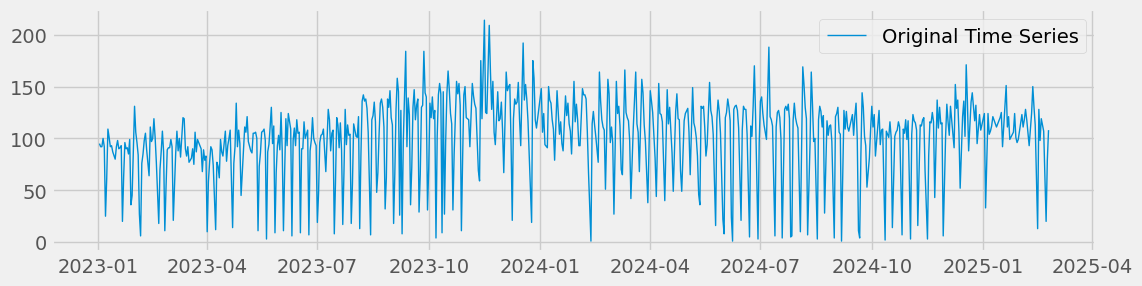

In [4]:
plt.figure(figsize=(12,3))
plt.plot(df, label='Original Time Series', linewidth=1)
plt.legend()
plt.show()

In [5]:
df_teste = df[df.index<'2025-01-01']
df_teste.tail()

,total_loads
start_of_operation,
2024-12-25,117
2024-12-26,132
2024-12-27,95
2024-12-29,123
2024-12-30,108


<Figure size 1800x300 with 0 Axes>

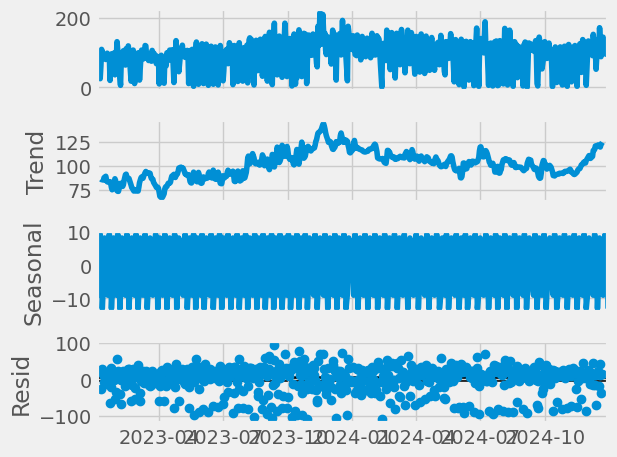

In [6]:
decompose_orig = seasonal_decompose(df[df.index<'2025-01-01'], model='additive', period=12)
plt.figure(figsize=(18,3))
decompose_orig.plot().show()

### Time Series Features

In [7]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday', 'Tuesday',
                                       'Wednesday', 
                                       'Thursday', 'Friday',
                                       'Saturday', 'Sunday'], 
                           ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    # df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    # df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    # df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
    #                       labels=['Spring', 'Summer', 'Fall', 'Winter']
                   # )
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='total_loads')
features_and_target = pd.concat([X, y], axis=1)

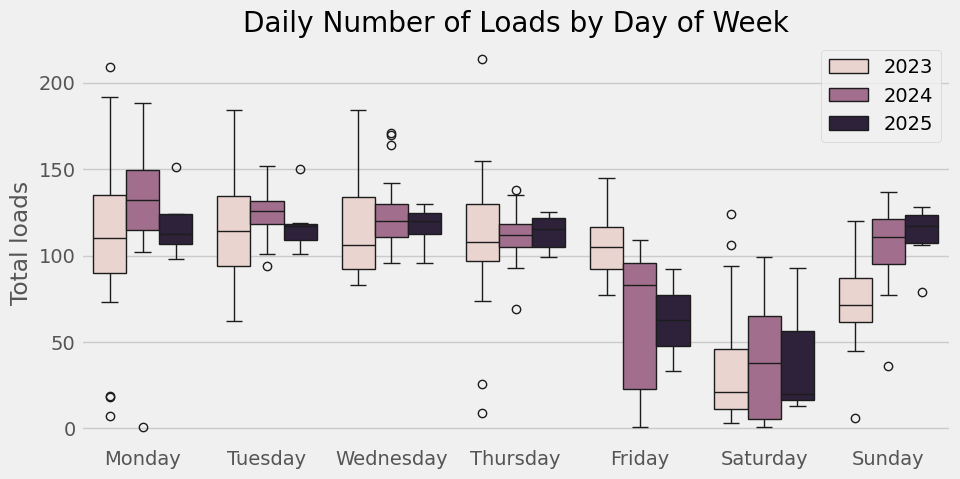

In [33]:
# grouped by week
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='total_loads',
            hue='year',
            ax=ax,
            linewidth=1)
ax.set_title('Daily Number of Loads by Day of Week')
ax.set_xlabel('')
ax.set_ylabel('Total loads')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

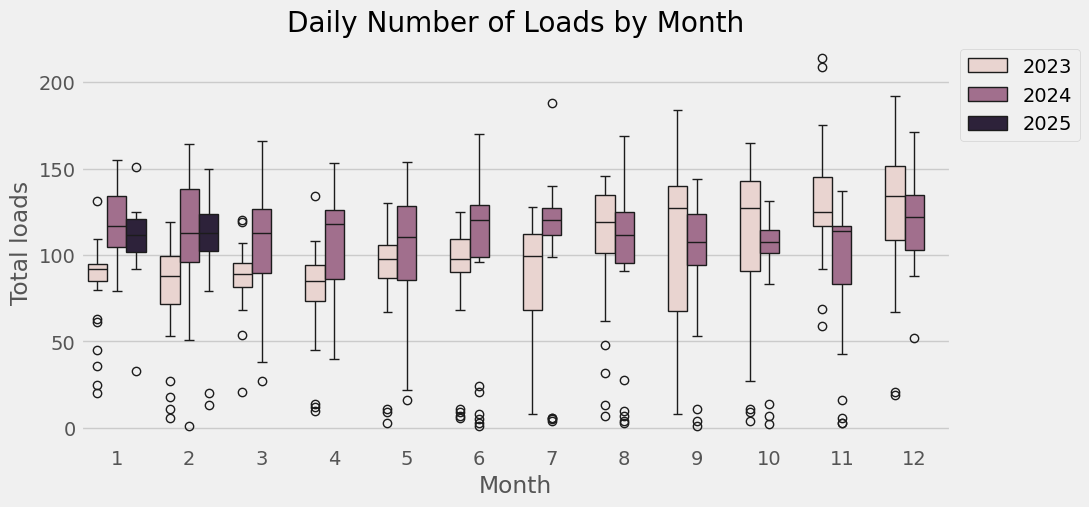

In [32]:
# grouped by month
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='month',
            y='total_loads',
            hue='year',
            ax=ax,
            linewidth=1)
ax.set_title('Daily Number of Loads by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Total loads')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In [10]:
features_and_target.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,total_loads
start_of_operation,,,,,,,,,
2023-01-02,0,1,1,2023,2,2,1,Monday,95
2023-01-03,1,1,1,2023,3,3,1,Tuesday,92
2023-01-04,2,1,1,2023,4,4,1,Wednesday,92
2023-01-05,3,1,1,2023,5,5,1,Thursday,100
2023-01-06,4,1,1,2023,6,6,1,Friday,92


### Grouping data by week and month

In [11]:
df_month = features_and_target.groupby(['year','month'], as_index=False)['total_loads'].sum()
df_month.head()

,year,month,total_loads
0,2023,1,2426
1,2023,2,2054
2,2023,3,2348
3,2023,4,2035
4,2023,5,2608


In [12]:
df_month.shape

(26, 3)

In [13]:
df_month['month_year'] = df_month['month'].astype(str)+'-'+df_month['year'].astype(str)
df_month['month_year'] = pd.to_datetime(df_month['month_year'])
df_month.head()

,year,month,total_loads,month_year
0,2023,1,2426,2023-01-01
1,2023,2,2054,2023-02-01
2,2023,3,2348,2023-03-01
3,2023,4,2035,2023-04-01
4,2023,5,2608,2023-05-01


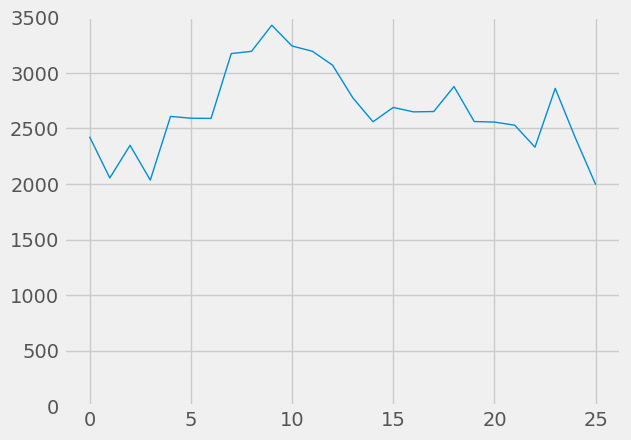

In [14]:
df_month['total_loads'].plot(linewidth=1)
plt.ylim(0,3500)
plt.show()

In [15]:
df_week = features_and_target.groupby(['year','weekofyear'], as_index=False)['total_loads'].sum()
df_week.head()

,year,weekofyear,total_loads
0,2023,1,557
1,2023,2,562
2,2023,3,547
3,2023,4,542
4,2023,5,537


In [16]:
df_week.shape

(113, 3)

In [17]:
df_week.dtypes

year            int32
weekofyear     UInt32
total_loads     int64
dtype: object

<Axes: >

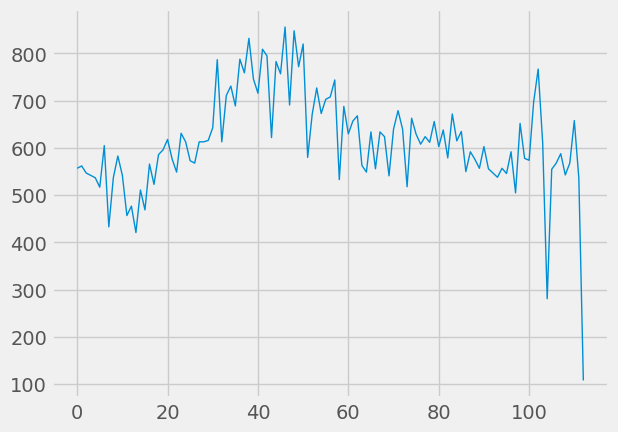

In [18]:
df_week['total_loads'].plot(linewidth=1)

### Training data

In [19]:
df_train = df_month.loc[df_month['month_year']<'01-2025', ['month_year','total_loads']]
df_train.tail()

,month_year,total_loads
19,2024-08-01,2562
20,2024-09-01,2557
21,2024-10-01,2529
22,2024-11-01,2331
23,2024-12-01,2860


In [20]:
df_train_decomp = df_train.set_index('month_year')
df_train_decomp.tail()

,total_loads
month_year,
2024-08-01,2562
2024-09-01,2557
2024-10-01,2529
2024-11-01,2331
2024-12-01,2860


In [21]:
df_test = df_month.loc[(df_month['month_year']>='01-2025')&(df_month['month_year']<'02-2025'), ['month_year','total_loads']]
df_test_decomp = df_test.set_index('month_year')
df_test_decomp

,total_loads
month_year,
2025-01-01,2412


### Decomposing the training data

https://medium.com/towards-data-science/getting-started-predicting-time-series-data-with-facebook-prophet-c74ad3040525#:~:text=Conclusion,enhance%20your%20time%20series%20forecasting.

https://www.geeksforgeeks.org/time-series-decomposition-techniques/

In [23]:
decompose = seasonal_decompose(df_train_decomp, model='additive')


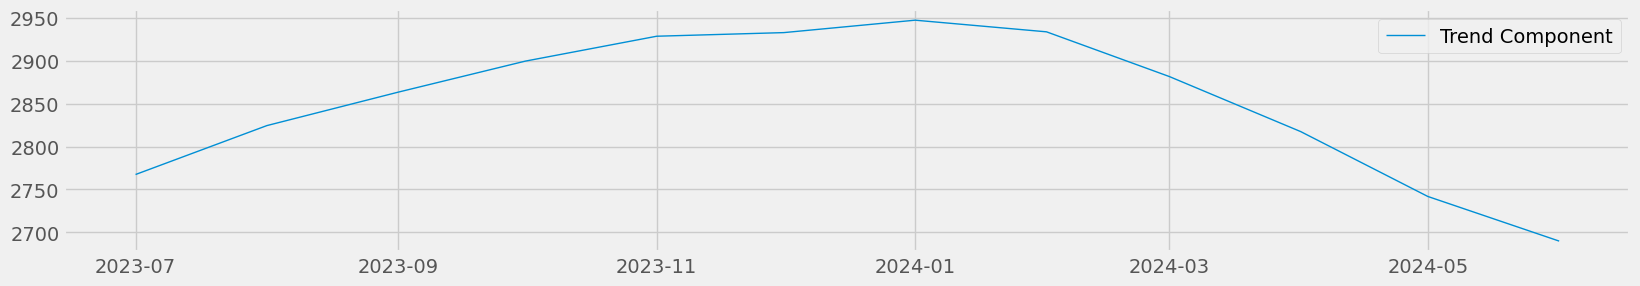

In [24]:
plt.figure(figsize=(18, 3))

plt.plot(decompose.trend, label='Trend Component', linewidth=1)
plt.legend(loc='upper right')
plt.show()

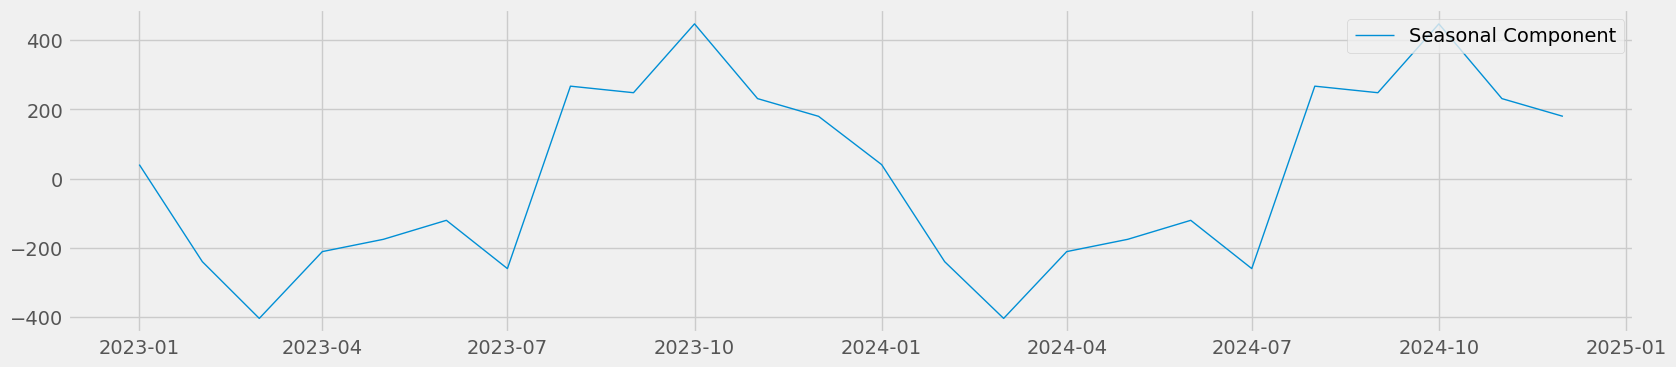

In [25]:
plt.figure(figsize=(18, 4))

plt.plot(decompose.seasonal, label='Seasonal Component', linewidth=1)
plt.legend(loc='upper right')
plt.show()

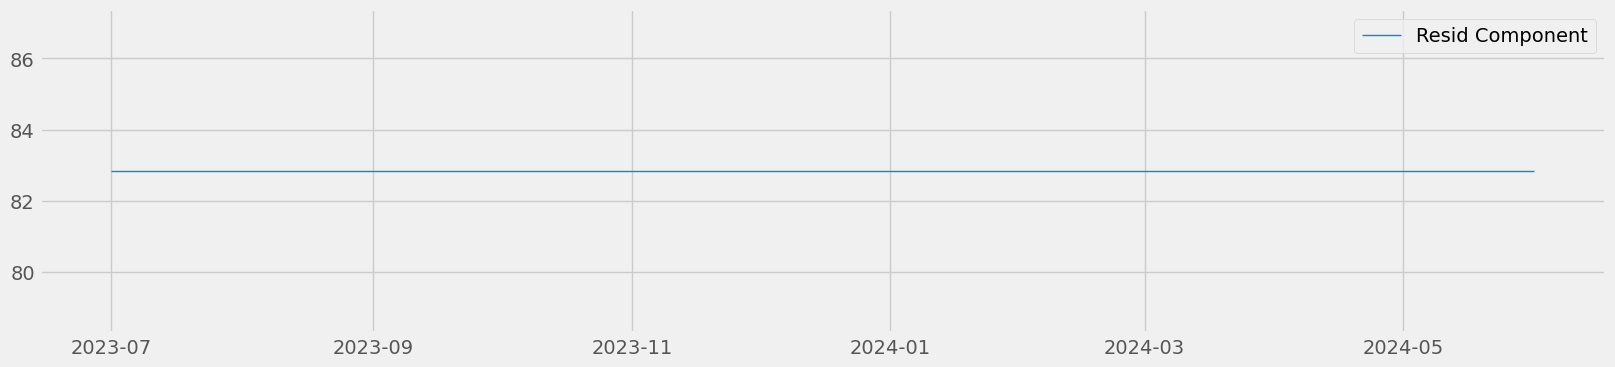

In [26]:
plt.figure(figsize=(18, 4))

plt.plot(decompose.resid, label='Resid Component', linewidth=1)
plt.legend(loc='upper right')
plt.show()

### Simple Model

In [27]:
# renaming the columns according to prophet's config

df_train_prophet = df_train.copy()

df_train_prophet = df_train_prophet.rename(columns = {'month_year':'ds'})
df_train_prophet = df_train_prophet.rename(columns = {'total_loads':'y'})
df_train_prophet

,ds,y
0,2023-01-01,2426
1,2023-02-01,2054
2,2023-03-01,2348
3,2023-04-01,2035
4,2023-05-01,2608
5,2023-06-01,2592
6,2023-07-01,2590
7,2023-08-01,3174
8,2023-09-01,3194
9,2023-10-01,3429


In [28]:
model_prophet  = Prophet()
model_prophet.fit(df_train_prophet)

14:49:52 - cmdstanpy - INFO - Chain [1] start processing
14:49:53 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
# making predictions

df_future = model_prophet.make_future_dataframe(periods=1, freq='MS')
display(df_future)

,ds
0,2023-01-01
1,2023-02-01
2,2023-03-01
3,2023-04-01
4,2023-05-01
5,2023-06-01
6,2023-07-01
7,2023-08-01
8,2023-09-01
9,2023-10-01


In [30]:
forecast_prophet = model_prophet.predict(df_future)
forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

,ds,yhat,yhat_lower,yhat_upper
20,2024-09-01,2774.0,2334.0,3224.0
21,2024-10-01,2781.0,2323.0,3240.0
22,2024-11-01,2789.0,2331.0,3258.0
23,2024-12-01,2797.0,2331.0,3285.0
24,2025-01-01,2804.0,2364.0,3246.0


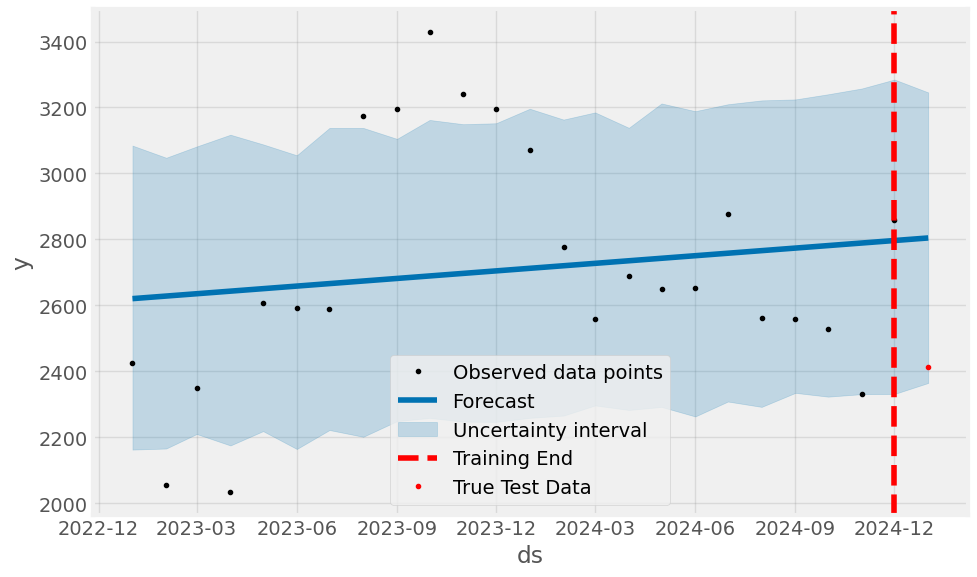

In [31]:

# plot the time series 
forecast_plot = model_prophet.plot(forecast_prophet)

# add a vertical line at the end of the training period
axes = forecast_plot.gca()
last_training_date = forecast_prophet['ds'].iloc[-2]
axes.axvline(x=last_training_date, color='red', linestyle='--', label='Training End')

# plot true test data for the period after the red line
# df_test['month_year'] = pd.to_datetime(df_test['month_year'])
plt.plot(df_test['month_year'], df_test['total_loads'],'ro', markersize=3, label='True Test Data')

# show the legend to distinguish between the lines
plt.legend()

In [ ]:
gh